## LSTM Example

Here i am writing an example pipeline for training and testing a LSTM model

In [1]:
%load_ext autoreload

In [392]:
# reloading modules after modifying code
%autoreload

In [1]:
import sys, os
import pandas as pd
import polars as pl
import numpy as np
from dotenv import load_dotenv

sys.path.append('/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting')
# when running on JupyterHub the dot-env-path needs to be adapted
load_dotenv("../.env")

datetime_format = "%Y-%m-%d %H:%M%z"

In [2]:
from src.neuro_symbolic_demand_forecasting.database.weather_postgres import WeatherDao
from src.neuro_symbolic_demand_forecasting.database.snowflake import SnowflakeDao


sf_dao = SnowflakeDao(
    url=os.getenv("SNOWFLAKE_URL"),
    uid=os.getenv("SNOWFLAKE_UID"),
    pwd=os.getenv("SNOWFLAKE_PASSWORD"),
    database=os.getenv("SNOWFLAKE_DATABASE"),
    schema=os.getenv("SNOWFLAKE_SCHEMA"),
)
pg_dao = WeatherDao(
    url=os.getenv("POSTGRES_HOST_WEATHER_DATA"),
    uid=os.getenv("POSTGRES_UID_WEATHER_DATA"),
    pwd=os.getenv("POSTGRES_PWD_WEATHER_DATA"),
    database=os.getenv("POSTGRES_DATABASE_WEATHER_DATA"),
    schema=os.getenv("POSTGRES_SCHEMA_WEATHER_DATA"),
    port=int(os.getenv("POSTGRES_PORT_WEATHER_DATA"))
)
sf_dao.connect()
pg_dao.connect()

Connected to snowflake instance!
Connected to postgres host!


### Querying database

In [3]:
contract_df = sf_dao.fetch_list("SELECT * FROM SANDBOX.KATRIN.CONTRACT_DATA")
contract_df

Executing query
Writing data to df


clusterreference,degreeofisolation,hassolarpanels,solarpanelswattpeak,surfacearea,typeofhouse,yearbuilt,numberofpeople,connection_id,ean,ean_sha256,previous_contract_id,contract_id,initial_contract_id,parent_contract_id,contract_start_date,contract_end_date,contract_state,pricing_type,market_segment,connection_group_id,customer_size,zip_code,city,zip_code_suffixed,last_modified
str,str,bool,f64,str,str,str,str,str,str,str,str,str,str,str,datetime[ns],datetime[ns],str,str,str,str,str,str,str,str,datetime[ns]
"""1115GD50""","""Average""",true,0.0,"""From100""","""RowHouse""","""From1975""","""FiveOrMore""","""68ce711c-9591-…","""87168590000933…","""d2f040441a8acd…","""0af1e053-ca98-…","""448260f8-6d06-…","""da881f3d-23d2-…","""448260f8-6d06-…",2021-04-03 00:00:00,2024-04-03 00:00:00,"""Active""","""Fixed""","""Electricity""","""c4d6d8b3-5e64-…","""Small""","""1115""","""DUIVENDRECHT""","""1115 GD""",2024-03-28 12:03:53
"""6581CV14""","""Average""",true,1650.0,"""From150""","""SemiDetached""","""From1965""","""Four""","""17a34041-7cf5-…","""87168712005393…","""7378f311a78a6a…","""76579388-3d66-…","""d10b02e1-e619-…","""76579388-3d66-…","""d10b02e1-e619-…",2021-11-17 00:00:00,2024-11-17 00:00:00,"""Active""","""Fixed""","""Electricity""","""c237f756-1934-…","""Small""","""6581""","""MALDEN""","""6581 CV""",2024-03-28 12:03:53
"""2693EA117""","""Good""",true,2880.0,"""From100""","""RowHouse""","""From2015""","""Four""","""f2f0b7b6-0166-…","""87168780000164…","""a8e16072cbc843…",null,"""d0580984-1693-…","""d0580984-1693-…","""d0580984-1693-…",2021-05-16 00:00:00,2024-05-16 00:00:00,"""Active""","""Fixed""","""Electricity""","""eea5f333-513d-…","""Small""","""2693""","""'S-GRAVENZANDE…","""2693 EA""",2024-03-28 12:03:53
"""9651CN7""","""Average""",true,18.0,"""From100""","""Detached""","""Until1945""","""Two""","""75e3c479-2b91-…","""87169484000471…","""6d9427b80268e4…","""31392f24-87f5-…","""5a7af430-3586-…","""5f49c6c2-2e21-…","""5a7af430-3586-…",2021-09-21 00:00:00,2024-09-21 00:00:00,"""Active""","""Fixed""","""Electricity""","""2c39d841-b4e0-…","""Small""","""9651""","""MEEDEN""","""9651 CN""",2024-03-28 12:03:53
"""1602JB17""","""Good""",true,3000.0,"""From100""","""CornerHouse""","""From1975""","""Two""","""65bfaff3-fb48-…","""87168590000451…","""955668d647fe7c…","""935de9fd-c8a0-…","""4d5fadc8-f660-…","""8dc04ec1-dbdf-…","""4d5fadc8-f660-…",2021-11-27 00:00:00,2024-11-27 00:00:00,"""Active""","""Fixed""","""Electricity""","""0c5d50b7-7acb-…","""Small""","""1602""","""ENKHUIZEN""","""1602 JB""",2024-03-28 12:03:53
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""6824BG47-402""","""Good""",false,0.0,"""From50""","""Apartment""","""From2015""","""One""","""dc6a400a-bee8-…","""87168711000392…","""9a34265969c949…",null,"""28c2891a-6fdb-…","""28c2891a-6fdb-…","""28c2891a-6fdb-…",2021-06-07 00:00:00,2024-06-07 00:00:00,"""Active""","""Fixed""","""Electricity""","""3268ee71-efd9-…","""Small""","""6824""","""ARNHEM""","""6824 BG""",2024-03-28 12:03:53
"""3448CA5""","""Poor""",false,0.0,"""From15""","""Apartment""","""From1975""","""One""","""8f779647-e29a-…","""87168740000541…","""1803c7ac5248ba…","""d7e3e173-16f7-…","""ef25d703-6aad-…","""379c8d31-0002-…","""ef25d703-6aad-…",2021-06-08 00:00:00,2024-06-08 00:00:00,"""Active""","""Fixed""","""Electricity""","""8fb15b1c-c2de-…","""Small""","""3448""","""WOERDEN""","""3448 CA""",2024-03-28 12:03:53
"""6462GT37""","""Average""",false,0.0,"""From50""","""Apartment""","""From1975""","""One""","""e5ca7e4a-4e56-…","""87168854000338…","""a6773471e60dab…",null,"""c3ffe820-1ef8-…","""c3ffe820-1ef8-…","""c3ffe820-1ef8-…",2021-06-01 00:00:00,2024-06-01 00:00:00,"""Active""","""Fixed""","""Electricity""","""6bdba9cf-d4cc-…","""Small""","""6462""","""KERKRADE""","""6462 GT""",2024-03-28 12:03:53


In [4]:
from src.neuro_symbolic_demand_forecasting.helpers.constants import P4_TS_SUMMER

start, end = "2023-05-01 00:00+02:00", "2023-06-01 00:00+02:00"
columns = "EAN_SHA256, LDN, ODN, READINGDATE, LDN_DIFF, ODN_DIFF"
df = sf_dao.fetch_list(f"SELECT {columns} FROM {P4_TS_SUMMER} WHERE READINGDATE>='{start}' AND READINGDATE<='{end}' ORDER BY READINGDATE ASC;")
data = df 
data.head()

Executing query
Writing data to df


ean_sha256,ldn,odn,readingdate,ldn_diff,odn_diff
str,f64,f64,"datetime[ns, Etc/GMT-2]",f64,f64
"""F41ADB3BFAFB0B…",1.8798578e7,0.0,2023-05-01 00:00:00 +02,null,null
"""323AC806E28638…",3.03616e7,269474.0,2023-05-01 00:00:00 +02,null,null
"""8005BCAA7F0537…",9.993275e6,0.0,2023-05-01 00:00:00 +02,null,null
"""D5D6F91896FE7B…",1.4854725e7,0.0,2023-05-01 00:00:00 +02,null,null
"""BFF1768D8C62AD…",1.9260119e7,0.0,2023-05-01 00:00:00 +02,null,null


### Scaling Data to hourly

In [63]:
hourly_df = df.filter(pl.col('readingdate').dt.minute() == 0)

data = hourly_df

### Finding missing data

In [66]:
min_length = (data['readingdate'].max() - data['readingdate'].min()).days * 24

missing_points = pl.DataFrame()
for key, group  in data.group_by(['ean_sha256']):
    if len(group) < min_length:
        missing_points = pl.concat([missing_points, group])

missing_points

ean_sha256,ldn,odn,readingdate,ldn_diff,odn_diff
str,f64,f64,"datetime[ns, Etc/GMT-2]",f64,f64
"""63F0FBCED56F3E…",2316270.000,0.000,2023-05-01 00:00:00 +02,null,null
"""63F0FBCED56F3E…",2316660.000,0.000,2023-05-01 01:00:00 +02,316.000,0.000
"""63F0FBCED56F3E…",2316772.000,0.000,2023-05-01 02:00:00 +02,17.000,0.000
"""63F0FBCED56F3E…",2316820.000,0.000,2023-05-01 03:00:00 +02,8.000,0.000
"""63F0FBCED56F3E…",2317152.000,0.000,2023-05-01 04:00:00 +02,9.000,0.000
…,…,…,…,…,…
"""3059DB9BC069BC…",2442853.000,2023349.000,2023-05-31 20:00:00 +02,130.000,0.000
"""3059DB9BC069BC…",2443436.000,2023349.000,2023-05-31 21:00:00 +02,153.000,0.000
"""3059DB9BC069BC…",2444148.000,2023349.000,2023-05-31 22:00:00 +02,183.000,0.000


In [68]:
min_length

744

### Analyzing nature of missing data points

In [67]:
for key, group  in missing_points.group_by(['ean_sha256']):
    # if len(group) < 100:
    print(key, len(group))

('17E70CC371ADD97536F36D8BA57E572CD4374F4A4EE6464324138FAD29781B6D',) 734
('A332CCF4A1200D9A4E52911E96C514FB4F102524A57F75904B247621DD854726',) 736
('7FB821134849B759493732B64FFA017149BBCC7FD4136B343C4B2E3D0C02C9F2',) 736
('9A221C83F846BF70A6142380FF1F55E16442365F6DCFF99476DA8B33322E8E92',) 737
('9E5894EEDD1207F8528FBDE20A6151E42D5282E1A63F1A6330E269AC08EC41F2',) 734
('78513031E3B86DF5632171D801B8A543E63C61806185786DF6424DF7407E1066',) 734
('7C587AEFDD9F9CE138D80A7402EF7849F86B359C5DA4CCA39DF6BB0D2D406ACC',) 674
('6BFEDA2C98A6C3F10B23E84981E20EEE30FA10B85941B22FC8BF8E6211E1230C',) 583
('158855E47754D763FE8881329ACAE17EECBAFB579899720A3CF7908C07A1E8DB',) 736
('0FD4A52C4C1D8189B7F79947764B2E1926D1F8DD94D625433649BE8BCF11908A',) 739
('AF6D36E7ED30B4E4C16956226FF3A4A5F7D94EC1325D15D056FF4DE7DAA58583',) 740
('91DC81729B9B9C42D15BA3EE3AB5DBEF79B0BA7799B956F75A22F80B003D6B3D',) 738
('108A4EC29B5F910F810B20DB8FF11E0100AA28C2253CDDF4FB72D3ADE7B6872C',) 743
('14438004DB2EF198408C065F920BDA7E4CA8

In [ ]:
# if consecutive missing points is > 3 then we cant really interpolate, else that one has to go

In [106]:
# single data points <= 4 -> interpolate
# mutliple hours -> fill values from previous day (or -7 days ) with same time
import datetime

def check_nature_of_missing_data(data: polars.DataFrame, expected_min, expected_max):
    s = data['readingdate']
    actual_min, actual_max = s.min(), s.max()
    print(actual_min, actual_max)
    if(actual_min != expected_min):
        print("expected:", expected_min, "but got", actual_min)
    if(actual_max != expected_max):
        print("expected:", expected_max, "but got", actual_max)
    if (len(s) != ((actual_max-actual_min).days*24*4)):
        print((actual_max-actual_min).days, "days")
        print("Expected length of", (actual_max-actual_min).days*24*4,  "but got", len(s))
        complete_time_range = polars.datetime_range(start=actual_min, end=actual_max, interval='15m', time_unit="ns", eager=True)
        missing_timestamp = list(set(complete_time_range.to_list()).difference(set(s.to_list())))
        missing_timestamp.sort()
        prev_day =missing_timestamp[0] - datetime.timedelta(days=7)
        print(data.filter(polars.col('readingdate')==prev_day))
        print(missing_timestamp[0] - datetime.timedelta(days=7))
        # [print(a) for a in missing_timestamp]


mi, ma = df['readingdate'].min(), df['readingdate'].max()
check_nature_of_missing_data(subset, mi, ma)
# for key, group  in missing_points.group_by(['ean_sha256']):
#     print(key)
#     check_nature_of_missing_data(group['readingdate'], mi, ma)
#     print()


2023-05-01 00:00:00+02:00 2023-06-01 00:00:00+02:00
31 days
Expected length of 2976 but got 2930
shape: (1, 6)
┌────────────────────────┬─────────────┬─────────────┬───────────────────────┬──────────┬──────────┐
│ ean_sha256             ┆ ldn         ┆ odn         ┆ readingdate           ┆ ldn_diff ┆ odn_diff │
│ ---                    ┆ ---         ┆ ---         ┆ ---                   ┆ ---      ┆ ---      │
│ str                    ┆ f64         ┆ f64         ┆ datetime[ns,          ┆ f64      ┆ f64      │
│                        ┆             ┆             ┆ Etc/GMT-2]            ┆          ┆          │
╞════════════════════════╪═════════════╪═════════════╪═══════════════════════╪══════════╪══════════╡
│ 7624F366F6F16D5CD6AD09 ┆ 3.6254954e7 ┆ 1.4527745e7 ┆ 2023-05-02 12:15:00   ┆ 0.0      ┆ 504.0    │
│ 60AC437ACA…            ┆             ┆             ┆ +02                   ┆          ┆          │
└────────────────────────┴─────────────┴─────────────┴───────────────────────┴───

### Brute Force Approach, Kicking out data with missing datapoint

In [69]:
df_for_train = data.filter(~pl.col('ean_sha256').is_in(missing_points['ean_sha256'].unique()))
# df_for_train = df_for_train.filter(pl.col('readingdate').dt.minute() == 0)
data, df_for_train


(shape: (4_032_690, 6)
 ┌───────────────────────┬──────────────┬─────────────┬───────────────────────┬──────────┬──────────┐
 │ ean_sha256            ┆ ldn          ┆ odn         ┆ readingdate           ┆ ldn_diff ┆ odn_diff │
 │ ---                   ┆ ---          ┆ ---         ┆ ---                   ┆ ---      ┆ ---      │
 │ str                   ┆ f64          ┆ f64         ┆ datetime[ns,          ┆ f64      ┆ f64      │
 │                       ┆              ┆             ┆ Etc/GMT-2]            ┆          ┆          │
 ╞═══════════════════════╪══════════════╪═════════════╪═══════════════════════╪══════════╪══════════╡
 │ F41ADB3BFAFB0B9B7A078 ┆ 18798578.000 ┆ 0.000       ┆ 2023-05-01 00:00:00   ┆ null     ┆ null     │
 │ 1C8EACC047D…          ┆              ┆             ┆ +02                   ┆          ┆          │
 │ 323AC806E286389E8914A ┆ 30361600.000 ┆ 269474.000  ┆ 2023-05-01 00:00:00   ┆ null     ┆ null     │
 │ B9D4E4CC013…          ┆              ┆             ┆ +02

## Clustering

### Creating Random Cluster groups

In [70]:
pl.Config.set_float_precision(3)
# df_for_train = df_for_train.sort(['ean_sha256', 'readingdate'])
pipeline = (
    df_for_train.lazy()
    .with_columns(
        (pl.col('ldn') - pl.col('ldn').shift(1)).over('ean_sha256').alias('ldn_diff'),
        (pl.col('odn') - pl.col('odn').shift(1)).over('ean_sha256').alias('odn_diff')
    ).with_columns(
        (pl.col('ldn_diff') - pl.col('odn_diff')).alias('gross')
    )
)

result = pipeline.collect()
result

ean_sha256,ldn,odn,readingdate,ldn_diff,odn_diff,gross
str,f64,f64,"datetime[ns, Etc/GMT-2]",f64,f64,f64
"""F41ADB3BFAFB0B…",18798578.000,0.000,2023-05-01 00:00:00 +02,null,null,null
"""323AC806E28638…",30361600.000,269474.000,2023-05-01 00:00:00 +02,null,null,null
"""8005BCAA7F0537…",9993275.000,0.000,2023-05-01 00:00:00 +02,null,null,null
"""D5D6F91896FE7B…",14854725.000,0.000,2023-05-01 00:00:00 +02,null,null,null
"""BFF1768D8C62AD…",19260119.000,0.000,2023-05-01 00:00:00 +02,null,null,null
…,…,…,…,…,…,…
"""81BACC713CAA2B…",38301237.000,2117043.000,2023-06-01 00:00:00 +02,501.000,0.000,501.000
"""F8698740E2D119…",41065326.000,1335894.000,2023-06-01 00:00:00 +02,611.000,0.000,611.000
"""F240362F6F6161…",21923620.000,0.000,2023-06-01 00:00:00 +02,143.000,0.000,143.000


In [76]:
# aggregate 100 customers into one timeseries (about 50 timeseries)
eans = result['ean_sha256'].unique().to_list()
groups = [eans[i * 100 : (i + 1) * 100] for i in range((len(eans) + 100 - 1) // 100)]

dfs = []

for key, g in enumerate(groups):
   temp = result.filter(pl.col('ean_sha256').is_in(g)).group_by('readingdate').agg(
        pl.sum('ldn_diff'),
        -pl.sum('odn_diff'),
        pl.sum('gross')
    ).with_columns(
       pl.lit(key).alias("cluster")
      ).sort("readingdate")
   dfs.append(temp[1:-1])

agg_df = pl.concat(dfs)
agg_df

readingdate,ldn_diff,odn_diff,gross,cluster
"datetime[ns, Etc/GMT-2]",f64,f64,f64,i32
2023-05-01 01:00:00 +02,36227.000,-0.000,36227.000,0
2023-05-01 02:00:00 +02,32878.000,-0.000,32878.000,0
2023-05-01 03:00:00 +02,34024.000,-0.000,34024.000,0
2023-05-01 04:00:00 +02,30802.000,-0.000,30802.000,0
2023-05-01 05:00:00 +02,28797.000,-0.000,28797.000,0
…,…,…,…,…
2023-05-31 19:00:00 +02,28535.000,-31292.000,-2757.000,50
2023-05-31 20:00:00 +02,25681.000,-16400.000,9281.000,50
2023-05-31 21:00:00 +02,31023.000,-4445.000,26578.000,50


In [73]:
for key, group in agg_df.group_by('cluster'):
    print(key, group.describe())

9 shape: (9, 5)
┌────────────┬───────────────────────────┬───────────┬─────────────┬─────────┐
│ statistic  ┆ readingdate               ┆ ldn_diff  ┆ odn_diff    ┆ cluster │
│ ---        ┆ ---                       ┆ ---       ┆ ---         ┆ ---     │
│ str        ┆ str                       ┆ f64       ┆ f64         ┆ f64     │
╞════════════╪═══════════════════════════╪═══════════╪═════════════╪═════════╡
│ count      ┆ 743                       ┆ 743.000   ┆ 743.000     ┆ 743.000 │
│ null_count ┆ 0                         ┆ 0.000     ┆ 0.000       ┆ 0.000   │
│ mean       ┆ 2023-05-16 12:00:00+02:00 ┆ 26153.521 ┆ -29720.911  ┆ 9.000   │
│ std        ┆ null                      ┆ 9757.125  ┆ 37717.707   ┆ 0.000   │
│ min        ┆ 2023-05-01 01:00:00+02:00 ┆ 10058.000 ┆ -133495.000 ┆ 9.000   │
│ 25%        ┆ 2023-05-08 19:00:00+02:00 ┆ 18589.000 ┆ -56131.000  ┆ 9.000   │
│ 50%        ┆ 2023-05-16 12:00:00+02:00 ┆ 22795.000 ┆ -7800.000   ┆ 9.000   │
│ 75%        ┆ 2023-05-24 06:00:00+0

/var/folders/ks/_jlbnqgn7ks2yq2nrk1jy21w0000gp/T/ipykernel_5315/264295550.py:1: DeprecationWarning: `group_by` iteration will change to always return group identifiers as tuples. Pass `by` as a list to silence this warning, e.g. `group_by(['cluster'])`.
  for key, group in agg_df.group_by('cluster'):


In [359]:
def custom_format(x):
    # Format numbers less than 1e6 normally
    if abs(x) < 1e6:
        return "{:.6f}".format(x)
    else:
        # Format larger numbers with full precision
        return "{:,.0f}".format(x)

# Set the print options
np.set_printoptions(suppress=True, formatter={'float_kind': custom_format})

## Data Prep

In [506]:
# pl.Config.set_tbl_width_chars(None)
# pl.Config.set_tbl_cols(None)
pl.Config(fmt_str_lengths=50)

### Retrieving Weather Data and merging with p4 data

In [527]:
from src.neuro_symbolic_demand_forecasting.helpers.datetime_utils import to_ams_local_tz
weather_data = pg_dao.fetch_weather_forecast_by_grid_point(136141, result['readingdate'].min(), result['readingdate'].max())
weather_data['valid_datetime'] = weather_data['valid_datetime'].apply(lambda x: to_ams_local_tz(x))
weather_data = weather_data.drop(columns=['grid_point', 'latitude', 'longitude', 'batch_datetime'])
weather_data = pl.from_pandas(weather_data)
weather_data = weather_data.with_columns(pl.col('valid_datetime').dt.convert_time_zone('Etc/GMT-2'))

ValueError: Length mismatch: Expected axis has 0 elements, new values have 17 elements

In [44]:
weather_data = pl.read_csv('../2023_weather_data_06_run_summer.csv', try_parse_dates=True)
weather_data = weather_data.with_columns(pl.col('valid_datetime').dt.convert_time_zone('Etc/GMT-2'))
weather_data = weather_data.with_columns(pl.col('valid_datetime').dt.cast_time_unit('ns'))
weather_data

,grid_point,latitude,longitude,valid_datetime,batch_datetime,wind_speed_10m,wind_speed_50m,wind_blast_speed_10m,t_instant_ground_2m,td_instant_ground_2m,pres_instant_sea_0m,pres_instant_ground_0m,r_instant_ground_2m,rain_instant_ground_0m,grad_accum_ground_0m,tcc_instant_ground_0m,vis_instant_ground_0m
i64,i64,f64,f64,"datetime[ns, Etc/GMT-2]","datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
65,136141,52.105,5.180,2023-04-01 02:00:00 +02,2023-03-31 06:00:00 UTC,5.080,7.142,10.466,282.157,281.587,99028.980,98975.190,0.961,0.000,0.000,1.000,2831.144
66,136141,52.105,5.180,2023-04-01 03:00:00 +02,2023-03-31 06:00:00 UTC,4.670,6.651,9.381,282.039,281.399,99040.470,98986.190,0.957,0.000,0.000,1.000,3154.285
68,136141,52.105,5.180,2023-04-01 05:00:00 +02,2023-03-31 06:00:00 UTC,4.050,5.691,8.315,281.495,281.064,99076.690,99022.500,0.970,0.000,0.000,1.000,2374.903
69,136141,52.105,5.180,2023-04-01 06:00:00 +02,2023-03-31 06:00:00 UTC,3.529,5.057,7.444,281.382,281.037,99098.980,99044.810,0.977,0.000,0.000,1.000,2021.720
70,136141,52.105,5.180,2023-04-01 07:00:00 +02,2023-03-31 06:00:00 UTC,2.916,4.099,6.624,281.340,281.156,99138.750,99084.690,0.987,0.000,0.000,1.000,1438.068
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
23344,136141,52.105,5.180,2023-07-31 10:00:00 +02,2023-07-31 06:00:00 UTC,6.577,9.386,12.629,289.058,288.364,100612.586,100558.440,0.956,0.000,25691.184,1.000,2796.526
23343,136141,52.105,5.180,2023-07-31 09:00:00 +02,2023-07-31 06:00:00 UTC,6.295,9.030,12.804,288.671,287.961,100640.970,100586.810,0.955,0.000,14418.781,1.000,3794.988
23358,136141,52.105,5.180,2023-08-01 00:00:00 +02,2023-07-31 06:00:00 UTC,3.309,5.911,7.048,289.522,289.035,100062.375,100009.875,0.969,0.000,0.000,0.998,2684.711


In [77]:
train_set = agg_df.join(weather_data.with_columns(pl.col('valid_datetime').alias('readingdate')), on='readingdate', how='left')
train_set

readingdate,ldn_diff,odn_diff,gross,cluster,,grid_point,latitude,longitude,valid_datetime,batch_datetime,wind_speed_10m,wind_speed_50m,wind_blast_speed_10m,t_instant_ground_2m,td_instant_ground_2m,pres_instant_sea_0m,pres_instant_ground_0m,r_instant_ground_2m,rain_instant_ground_0m,grad_accum_ground_0m,tcc_instant_ground_0m,vis_instant_ground_0m
"datetime[ns, Etc/GMT-2]",f64,f64,f64,i32,i64,i64,f64,f64,"datetime[ns, Etc/GMT-2]","datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-05-01 01:00:00 +02,36227.000,-0.000,36227.000,0,5808,136141,52.105,5.180,2023-05-01 01:00:00 +02,2023-04-30 06:00:00 UTC,1.803,4.890,3.317,283.258,279.629,101868.950,101812.500,0.781,0.000,0.000,1.000,50000.000
2023-05-01 02:00:00 +02,32878.000,-0.000,32878.000,0,5809,136141,52.105,5.180,2023-05-01 02:00:00 +02,2023-04-30 06:00:00 UTC,2.088,5.169,3.860,282.852,279.135,101829.984,101773.625,0.776,0.000,0.000,1.000,50000.000
2023-05-01 03:00:00 +02,34024.000,-0.000,34024.000,0,5810,136141,52.105,5.180,2023-05-01 03:00:00 +02,2023-04-30 06:00:00 UTC,1.934,4.700,3.852,282.793,278.476,101747.050,101690.690,0.744,0.000,0.000,1.000,50000.000
2023-05-01 04:00:00 +02,30802.000,-0.000,30802.000,0,5811,136141,52.105,5.180,2023-05-01 04:00:00 +02,2023-04-30 06:00:00 UTC,1.708,4.020,3.584,282.952,277.956,101658.560,101601.940,0.710,0.000,0.000,1.000,50000.000
2023-05-01 05:00:00 +02,28797.000,-0.000,28797.000,0,5812,136141,52.105,5.180,2023-05-01 05:00:00 +02,2023-04-30 06:00:00 UTC,1.535,3.637,3.164,282.876,277.680,101603.680,101547.125,0.700,0.000,0.000,1.000,50000.000
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2023-05-31 19:00:00 +02,28535.000,-31292.000,-2757.000,50,11754,136141,52.105,5.180,2023-05-31 19:00:00 +02,2023-05-31 06:00:00 UTC,5.632,7.732,11.140,293.328,284.803,102337.300,102284.625,0.579,0.000,1452768.000,0.627,50000.000
2023-05-31 20:00:00 +02,25681.000,-16400.000,9281.000,50,11755,136141,52.105,5.180,2023-05-31 20:00:00 +02,2023-05-31 06:00:00 UTC,5.125,7.055,10.924,291.842,284.426,102314.480,102261.750,0.620,0.000,899375.000,0.897,50000.000
2023-05-31 21:00:00 +02,31023.000,-4445.000,26578.000,50,11756,136141,52.105,5.180,2023-05-31 21:00:00 +02,2023-05-31 06:00:00 UTC,4.413,6.603,9.718,289.934,283.929,102336.950,102283.560,0.677,0.000,395482.000,0.915,50000.000


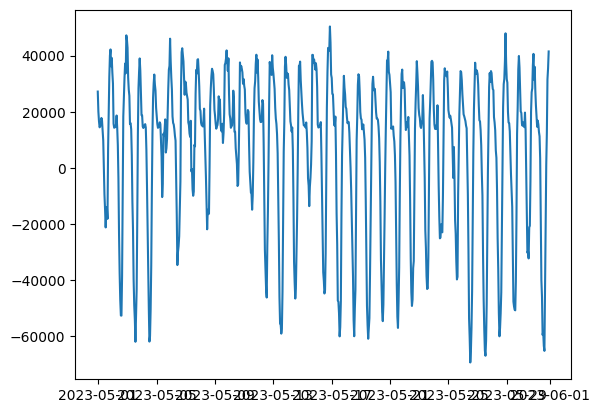

In [101]:
import matplotlib.pyplot as plt

df_for_plot = train_set.filter(pl.col('cluster') == 15)

fig, ax = plt.subplots()
ax.plot(df_for_plot['readingdate'],df_for_plot['gross'])
plt.show()

In [93]:
from src.neuro_symbolic_demand_forecasting.helpers.dataset_utils import create_dataset_from_clustered_df, create_X_y_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

source_size = 24*5 # input size (24*4 -> PTUs * days) + target_size (24*4 -> PTUs) * days
target_size = 24*1
rolling_window_size = 12

# ['readingdate', 'ldn_diff', 'odn_diff', 'gross', 'cluster', '', 
# 'grid_point', 'latitude', 'longitude', 'valid_datetime', 'batch_datetime', 
# 'wind_speed_10m', 'wind_speed_50m', 'wind_blast_speed_10m', 
# 't_instant_ground_2m', 'td_instant_ground_2m', 'pres_instant_sea_0m', 
# 'pres_instant_ground_0m', 'r_instant_ground_2m', 'rain_instant_ground_0m', 
# 'grad_accum_ground_0m', 'tcc_instant_ground_0m', 'vis_instant_ground_0m']

sub_df = train_set.select('gross', 'cluster', 'wind_speed_10m', 't_instant_ground_2m', 'grad_accum_ground_0m')
dataset  = create_dataset_from_clustered_df(sub_df.group_by(['cluster']), source_size, rolling_window_size=rolling_window_size)
lll = dataset.as_numpy_iterator()

lll = np.concatenate(list(lll), axis=0)

print(list(enumerate(sub_df.columns)))
target_column_index = 0

sub_lll = lll#[:, :, 2:3]
scaler = StandardScaler()

# scaler requires a 2d array, so we reshape our data for that sake and then immediatly shape it back
scaled_lll = scaler.fit_transform(X=sub_lll.reshape(-1,sub_lll.shape[-1])).reshape(sub_lll.shape)

X, y = create_X_y_split(scaled_lll, target_size, target_column_index=target_column_index)
print(X.shape, y.shape, len(lll))

['readingdate', 'ldn_diff', 'odn_diff', 'gross', 'cluster', '', 'grid_point', 'latitude', 'longitude', 'valid_datetime', 'batch_datetime', 'wind_speed_10m', 'wind_speed_50m', 'wind_blast_speed_10m', 't_instant_ground_2m', 'td_instant_ground_2m', 'pres_instant_sea_0m', 'pres_instant_ground_0m', 'r_instant_ground_2m', 'rain_instant_ground_0m', 'grad_accum_ground_0m', 'tcc_instant_ground_0m', 'vis_instant_ground_0m']
[(0, 'gross'), (1, 'cluster'), (2, 'wind_speed_10m'), (3, 't_instant_ground_2m'), (4, 'grad_accum_ground_0m')]
(2652, 96, 5) (2652, 24) 2652


2024-04-11 15:54:03.231215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training, Testing, Validating Split

70/20/10 split

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.09, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((1930, 96, 5), (1930, 24), (531, 96, 5), (531, 24), (191, 96, 5), (191, 24))

#### Old train test split + scaling

In [242]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming your dataframe is named 'df' and contains a datetime index
input_window_size = (24*4)*7  # 24h (* PTUs) * days
target_window_size = 4*8 # Predict next PTUs (15 min interval of the next X hours)


scaler = StandardScaler()

df = df_for_plot

df = df[1:-1]
df = df[['gross']]
df[['gross']] = scaler.fit_transform(X=df[['gross']])

# Generate input and target sequences
sequences = []
targets = []
for i in range(len(df) - input_window_size - target_window_size + 1):
    input_sequence = df[i:i+input_window_size]
    target_sequence = df[i+input_window_size:i+input_window_size+target_window_size]
    sequences.append(input_sequence)
    targets.append(target_sequence)

# Convert sequences and targets to numpy arrays
X = np.array([sequence.to_numpy() for sequence in sequences])
y = np.array([target.to_numpy() for target in targets])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1817, 672, 1), (1817, 32, 1), (455, 672, 1), (455, 32, 1))

### Custom Loss Function

In [83]:
def root_mse(y_true, y_pred):
    #difference between true label and predicted label
    error = y_true-y_pred    
    #square of the error
    sqr_error = tf.keras.backend.square(error)
    #mean of the square of the error
    mean_sqr_error = tf.keras.backend.mean(sqr_error)
    #square root of the mean of the square of the error
    sqrt_mean_sqr_error = tf.keras.backend.sqrt(mean_sqr_error)
    #return the error
    return sqrt_mean_sqr_error

### Training

In [95]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
import numpy as np

MAX_EPOCHS = 5

# Define hyperparameters
layer_units = [20, 5, 20]
dropout_rates = [0.4, 0.1, 0.16]
learning_rate = 1e-2

# model absed on LSTM-based Short-term Load Forecasting for Building Electricity Consumption
lstm_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(layer_units[0], return_sequences=True),
    Dropout(dropout_rates[0]),
    LSTM(layer_units[1], return_sequences=True),
    Dropout(dropout_rates[1]),
    LSTM(layer_units[2], activation='relu', return_sequences=False),
    Dropout(dropout_rates[2]),
    Dense(units=target_size)
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=2,
                                                mode='min')

lstm_model.compile(loss=root_mse,
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=['mean_absolute_error'])

print(lstm_model.summary())

# do not set batch size when using a keras PyDataset
history = lstm_model.fit(X_train, y_train, epochs=MAX_EPOCHS, callbacks=[early_stopping], validation_data=(X_val, y_val))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 96, 20)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 96, 5)          │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 96, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 20)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           504 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,184 (20.25 KB)

 Trainable params: 5,184 (20.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5


61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.6372 - mean_absolute_error: 0.3013 - val_loss: 0.2060 - val_mean_absolute_error: 0.1453
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.4864 - mean_absolute_error: 0.1610 - val_loss: 0.1808 - val_mean_absolute_error: 0.1281
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.7808 - mean_absolute_error: 0.1680 - val_loss: 0.1478 - val_mean_absolute_error: 0.1064
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.4087 - mean_absolute_error: 0.1361 - val_loss: 0.1369 - val_mean_absolute_error: 0.0999
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.3298 - mean_absolute_error: 0.1302 - val_loss: 0.1418 - val_mean_absolute_error: 0.1045


In [96]:
y_predict = lstm_model.predict(X_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [97]:
print(y_predict.shape, y_test.shape, X_test.shape)

# y_predict = np.concatenate((X_test,y_predict.reshape(y_test.shape)), axis=1)
# y_actual = np.concatenate((X_test[:,:,target_column_index],y_test), axis=1)
# print(y_predict.shape, y_actual.shape, X_test.shape)

(531, 24) (531, 24) (531, 96, 5)


## Evaluation

#### Plotting predicted vs. actual

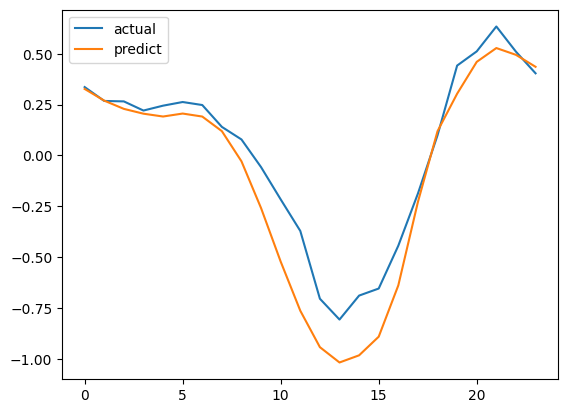

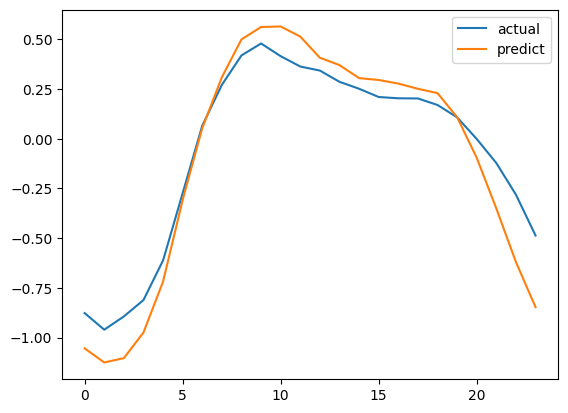

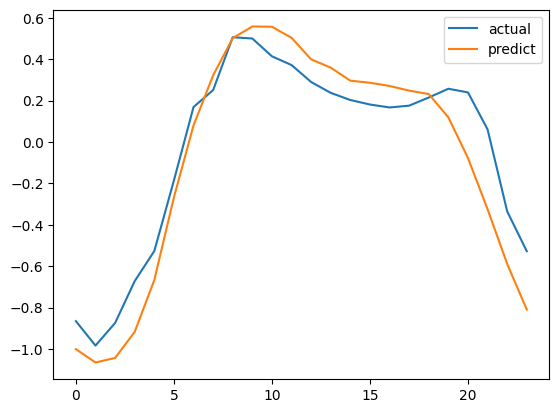

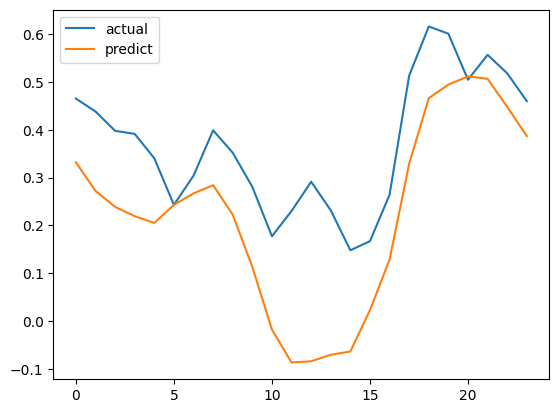

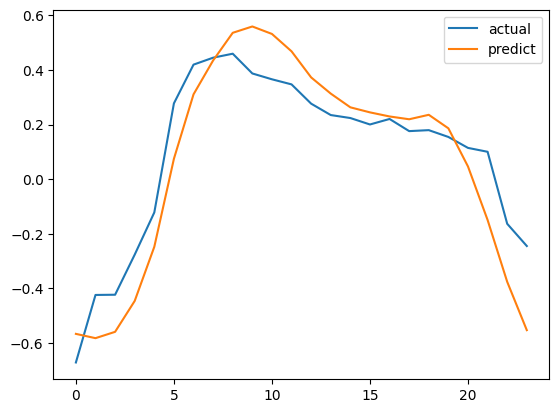

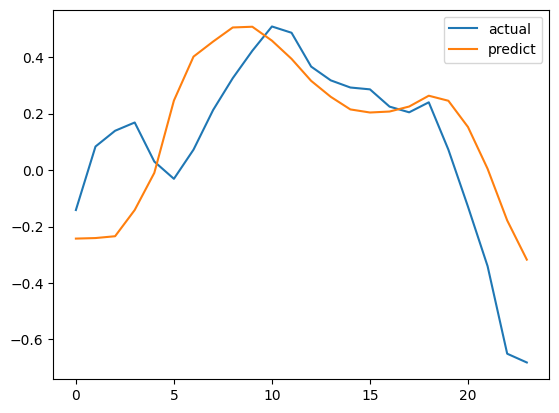

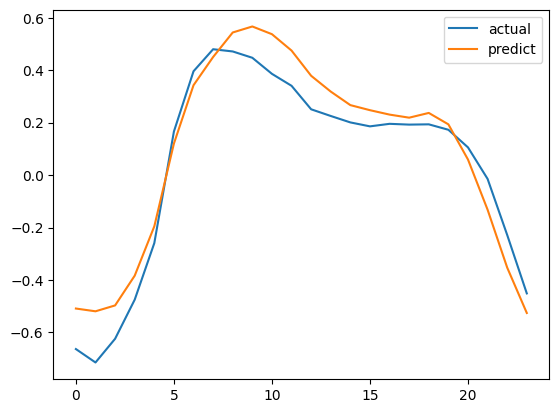

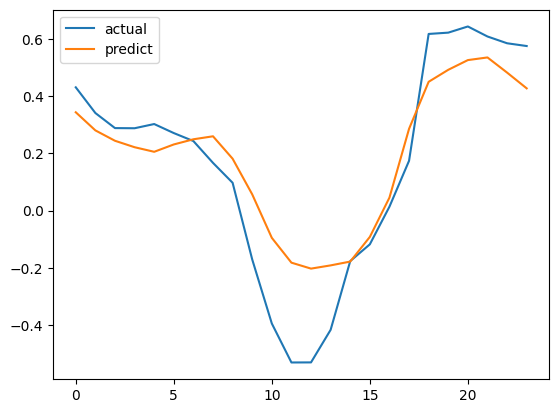

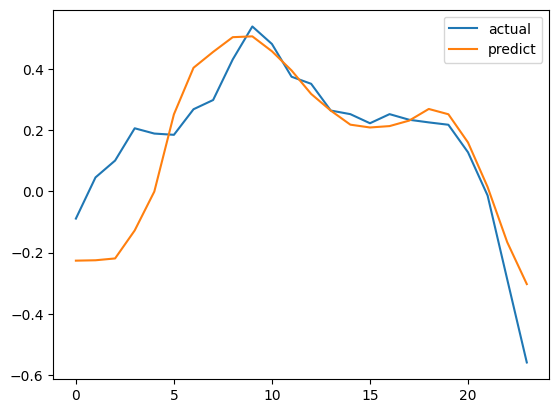

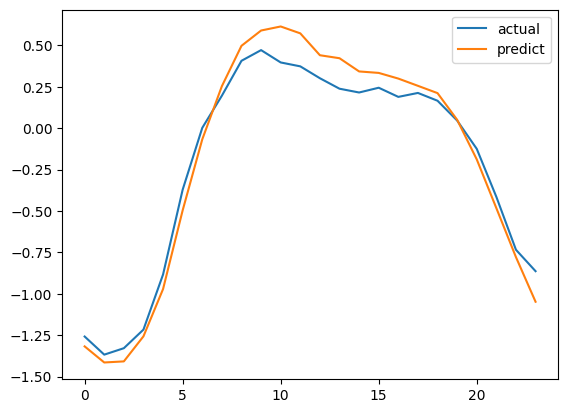

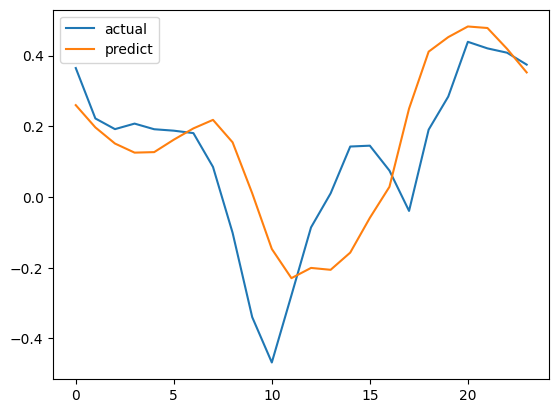

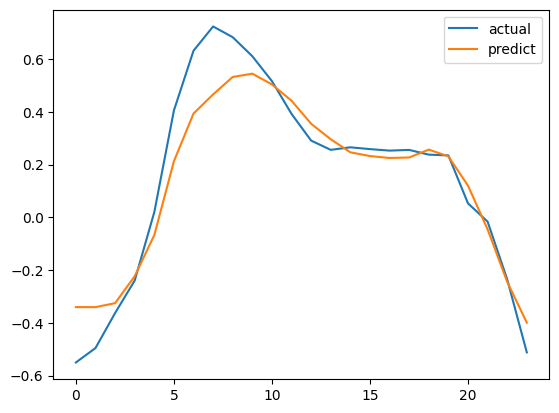

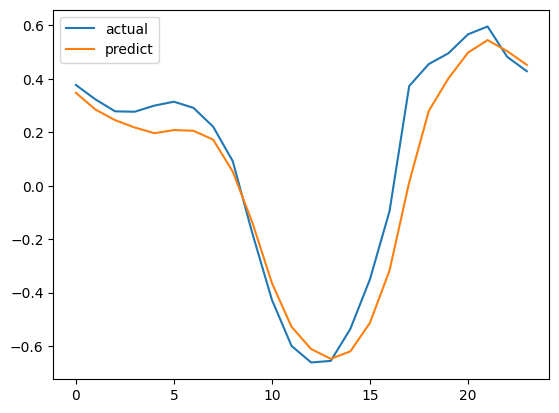

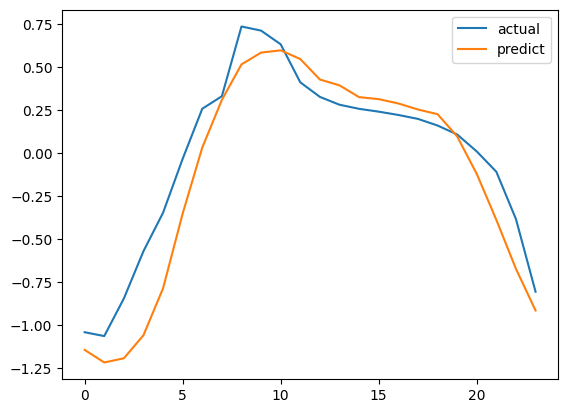

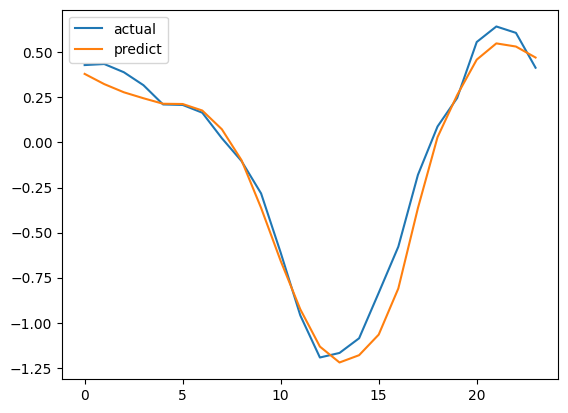

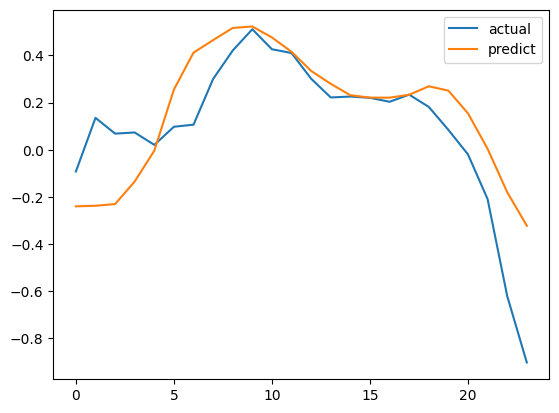

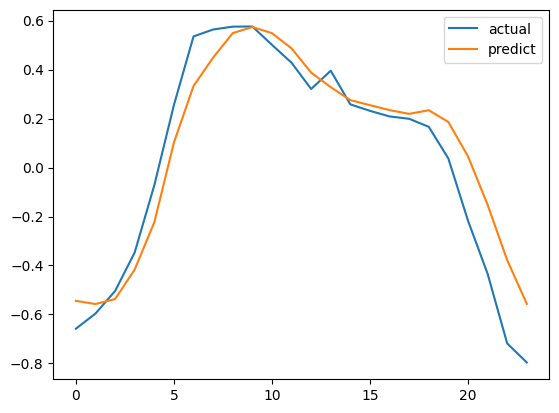

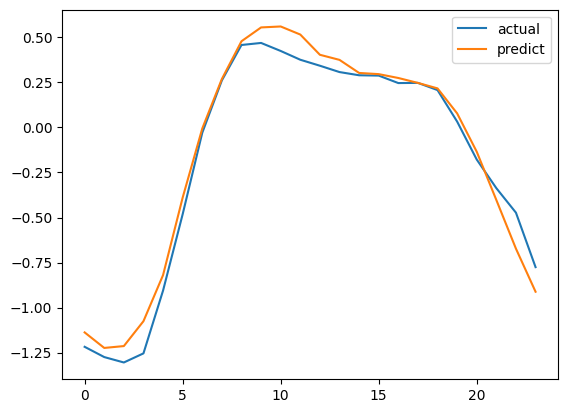

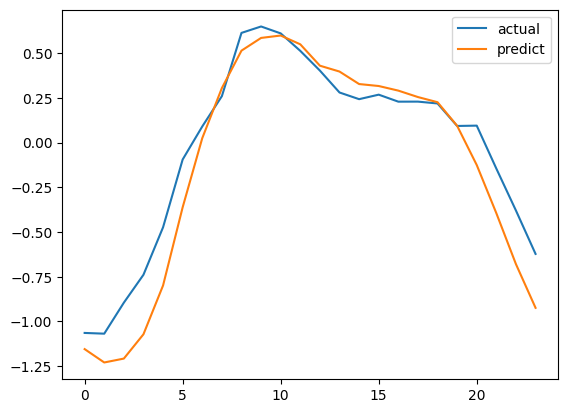

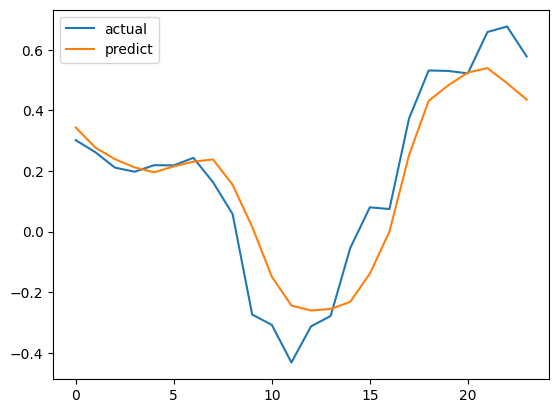

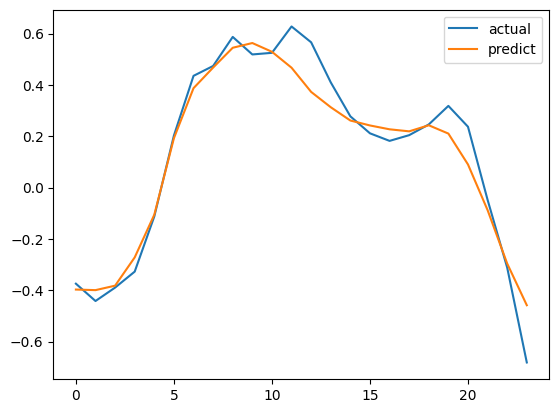

In [100]:
y_a = y_test #scaler.inverse_transform(y_test)
y_p = y_predict # scaler.inverse_transform(y_predict)

for i in range(0, len(y_predict)):
    a = range(0, len(y_test[i]))
    # plt.plot(a, y_test[i])
    plt.plot(a, y_a[i])
    # plt.plot(a, y_predict[i])
    plt.plot(a, y_p[i])
    plt.legend(['actual','predict'])
    plt.show()
    if i >= 20:
        break

#### Plotting full actual graph with minisection of predicted values

In [441]:
i = 1

target_column_index = 1

X_test_plot = X_test[:,:,target_column_index]

for i in range(0, len(y_predict)):
    a = range(0, len(y_actual[i]))
    y_a = scaler.inverse_transform(y_actual[i])

    b=range(len(X_test_plot[i]), len(y_actual[i]))

    y_p = scaler.inverse_transform(y_predict[i].reshape(len(y_predict[i]),1))

    plt.plot(a, y_a)

    plt.plot(b, y_p)
    plt.show()
    if i >= 10:
        break

ValueError: Expected 2D array, got 1D array instead:
array=[0.202201 0.218336 0.228990 0.217752 0.201440 0.155980 0.138628 0.169705
 0.147203 0.127086 0.128659 0.111789 0.097481 0.097633 0.099510 0.105117
 0.098978 0.108897 0.101717 0.105142 0.096796 0.095604 0.099815 0.106816
 0.105903 0.102960 0.110165 0.124523 0.108059 0.095401 0.115771 0.187310
 0.130079 0.117928 0.137360 0.099815 0.089008 0.042127 0.018078 -0.032735
 -0.064090 -0.063329 -0.096587 -0.155442 -0.229873 -0.219345 -0.215235
 -0.249660 -0.307652 -0.333325 -0.410546 -0.389592 -0.397507 -0.387994
 -0.405447 -0.417066 -0.461638 -0.388526 -0.415265 -0.426655 -0.363513
 -0.333579 -0.366025 -0.320742 -0.324243 -0.274622 -0.195524 -0.203084
 -0.124848 -0.063152 0.004100 0.058413 0.067394 0.140303 0.127213 0.117725
 0.116888 0.118613 0.130586 0.175691 0.160623 0.189035 0.214759 0.258063
 0.296622 0.268032 0.270290 0.271964 0.311209 0.305324 0.282822 0.269149
 0.277571 0.271711 0.279473 0.323411 0.271736 0.196696 0.183556 0.166077
 0.184241 0.202734 0.165367 0.134265 0.144767 0.116203 0.103595 0.109074
 0.122367 0.110063 0.089997 0.093422 0.097430 0.112778 0.099307 0.118790
 0.107273 0.107197 0.106131 0.101388 0.096593 0.096288 0.080154 0.071909
 0.041467 0.028377 0.009351 -0.000517 -0.013278 -0.051939 -0.067693
 -0.056226 -0.067261 -0.125862 -0.121524 -0.194864 -0.246540 -0.317064
 -0.328302 -0.377263 -0.403595 -0.413337 -0.464530 -0.479675 -0.535688
 -0.532872 -0.540711 -0.519985 -0.572092 -0.584598 -0.581250 -0.585157
 -0.532492 -0.567069 -0.573208 -0.584396 -0.547738 -0.511867 -0.474525
 -0.433530 -0.392382 -0.395224 -0.381855 -0.363716 -0.320767 -0.288879
 -0.244180 -0.193418 -0.103234 -0.038874 -0.003587 0.019473 0.033984
 0.062574 0.130257 0.227367 0.235916 0.196088 0.182236 0.215266 0.223029
 0.204332 0.238783 0.239036 0.251340 0.242080 0.239341 0.220391 0.196798
 0.225337 0.247408 0.213592 0.217854 0.190760 0.169679 0.207300 0.199842
 0.172850 0.153596 0.190989 0.155371 0.147228 0.156285 0.140074 0.144767
 0.130688 0.140531 0.135153 0.133834 0.129394 0.104609 0.107451 0.103798
 0.103341 0.098318 0.130637 0.103442 0.099130 0.087460 0.092230 0.075588
 0.050955 0.029849 0.025181 -0.014571 0.022644 0.035709 -0.021573
 -0.001836 -0.041842 -0.073121 -0.097120 -0.076851 -0.104477 -0.190577
 -0.241085 -0.278453 -0.318890 -0.344030 -0.387994 -0.356410 -0.342762
 -0.414960 -0.413641 -0.446924 -0.449842 -0.447356 -0.384721 -0.418131
 -0.405802 -0.379698 -0.360012 -0.293547 -0.319220 -0.293141 -0.248087
 -0.198619 -0.178730 -0.164092 -0.103589 -0.093568 -0.102397 -0.065257
 0.039235 0.034643 0.036039 0.095451 0.163921 0.202810 0.177924 0.150222
 0.206362 0.192308 0.183150 0.206920 0.185661 0.192663 0.239696 0.239265
 0.259153 0.251746 0.232187 0.215875 0.212856 0.195885 0.182845 0.170364
 0.172089 0.148395 0.127492 0.118739 0.115391 0.134620 0.106081 0.123915
 0.134189 0.104280 0.098014 0.094842 0.106284 0.114072 0.104990 0.099282
 0.117040 0.131297 0.131195 0.116735 0.104939 0.096263 0.099612 0.098597
 0.115365 0.110114 0.109277 0.106005 0.121631 0.120109 0.068079 0.094284
 0.066354 0.017469 0.013055 0.031929 0.051260 -0.013886 -0.049757
 -0.070534 -0.058509 -0.120915 -0.158334 -0.238067 -0.240680 -0.253668
 -0.237407 -0.232714 -0.239335 -0.220512 -0.167898 -0.149556 -0.170003
 -0.203718 -0.208868 -0.228503 -0.166376 -0.121575 -0.093518 -0.075227
 -0.095928 -0.084512 -0.077459 -0.105999 -0.076267 -0.034739 0.000092
 0.007474 0.008539 0.042355 0.098039 0.165113 0.181704 0.268692 0.239493
 0.219427 0.283710 0.230132 0.223003 0.291752 0.308546 0.293350 0.275440
 0.312402 0.251720 0.269402 0.252380 0.253496 0.211613 0.218133 0.202125
 0.189695 0.203673 0.202709 0.184317 0.187919 0.190380].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.